# Import necessary libraries


In [89]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re

pd.options.display.max_columns = 200
pd.options.display.max_rows = 3000

# Load the dataset 

In [90]:
def parent_directory():

  # Create a relative path to the parent
  # of the current working directory
  relative_parent = os.path.join(os.getcwd(), os.pardir)
  # Return the absolute path of the parent directory
  return os.path.abspath(relative_parent)

print(parent_directory())

def str_2_int(value):
  if ',' in value:
    x = float(value.replace(',',''))
    return x
  else :
    return float(value)

salaries = pd.read_csv(parent_directory() + '/final_project/0.Ressources/05_2_salaries.csv')


c:\Users\james\Documents


# Renaming Columns and Adding Total Remuneration

In [91]:


#Rename Column names because they were too long
salaries.columns = ['Time', 'Age', 'Industry', 'Job', 'Job Context', 'Salary', 'Bonus', 'Currency', 'Other Currency', 'Income Context', 'Country', 'US State', 'City', 'Experience', 'Field experience', 'Education', 'Gender', 'Race']

#Convert String to float
salaries["Salary"] = salaries["Salary"].apply(str_2_int)


#Replace NA values in Bonus by 0 and add a "Total Remuneration" Column
values = {"Bonus": 0.0}
salaries = salaries.fillna(value = values)
salaries["Total Remuneration"] = salaries["Salary"] + salaries["Bonus"]
move = salaries.pop("Total Remuneration")
salaries.insert(7,"Total Remuneration" ,move)


salaries


,Time,Age,Industry,Job,Job Context,Salary,Bonus,Total Remuneration,Currency,Other Currency,Income Context,Country,US State,City,Experience,Field experience,Education,Gender,Race
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000.0,0.0,55000.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600.0,4000.0,58600.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000.0,0.0,34000.0,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000.0,3000.0,65000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000.0,7000.0,67000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,9/25/2024 19:54:18,45-54,"Accounting, Banking & Finance",Product Manager Lead,NaN,117000.0,8000.0,125000.0,USD,NaN,NaN,USA,Missouri,Remote,11 - 20 years,11 - 20 years,College degree,Woman,White
28081,9/25/2024 21:34:43,45-54,Education (Primary/Secondary),Curriculum Writer,I am a freelance contract curriculum writer fo...,70000.0,0.0,70000.0,USD,NaN,NaN,United States,South Carolina,Bennettsville,21 - 30 years,21 - 30 years,Master's degree,Woman,White
28082,9/30/2024 10:52:30,55-64,Government and Public Administration,Clerical Officer,NaN,28600.0,0.0,28600.0,EUR,NaN,NaN,Ireland,NaN,Dublin,21 - 30 years,1 year or less,"Professional degree (MD, JD, etc.)",Man,White
28083,10/4/2024 13:05:24,18-24,Computing or Tech,Software Engineering Co-Op,I was an Intern,56160.0,0.0,56160.0,USD,NaN,NaN,United States,Rhode Island,Jhonston,1 year or less,1 year or less,College degree,Man,White


# Fixing Types

In [92]:
salaries["Time"] = pd.to_datetime(salaries["Time"], format='%m/%d/%Y %H:%M:%S')

#Did that because I noticed that some values were float in Industry
salaries['Industry'] = salaries['Industry'].astype(str)

salaries.dtypes

Time                  datetime64[ns]
Age                           object
Industry                      object
Job                           object
Job Context                   object
Salary                       float64
Bonus                        float64
Total Remuneration           float64
Currency                      object
Other Currency                object
Income Context                object
Country                       object
US State                      object
City                          object
Experience                    object
Field experience              object
Education                     object
Gender                        object
Race                          object
dtype: object

# Check Missing Values

In [93]:
pair_list = salaries["Currency"].unique()

In [94]:
missing_values = salaries.isnull().sum()
missing_percentage = (missing_values / len(salaries)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage})
missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
Other Currency,27878,99.262952
Income Context,25041,89.161474
Job Context,20818,74.124978
US State,5026,17.895674
Education,222,0.790458
Race,177,0.630230
Gender,171,0.608866
City,82,0.291971
Job,1,0.003561


We can therefore see that over 99.2% of the dataset is payed in one of the currencies listed in the "Currency" column. For this reason we think it would make sense to remove the other currencies from our analysis as they would not have a significant impact on the results. We will therefore analyse salaries from the US, Great Britain, Canada, Euro Zone, Australia and New Zealand, Switzerland, South Africa, Sweden, Hong Kong and Japan. This may bias our views due to it being focused on advanced economies.   

# Get current exchange rate

In [95]:
#We are going to use Selenium here to get the exchange rate of the currencies
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import ChromeService
import time

# instantiate a Chrome options object
options = webdriver.ChromeOptions()

# set the options to use Chrome in headless mode
options.add_argument("--headless=new")

# set the service to use chromedriver (for non-Mac environment especially)

service = ChromeService(executable_path='chromedriver.exe')

# initialize an instance of the chrome driver (browser) in headless mode
driver = webdriver.Chrome(service = service,
    options=options
)

# visit your target site
driver.get("https://www.oanda.com/currency-converter/live-exchange-rates/")

# extract all the product containers
rates = driver.find_elements(By.XPATH, "/html/body/div[1]/main/div/div/div[3]")

time.sleep(3)

In [96]:
def get_current_rates():
    def get_rate(rate):
        if rate == "EUR":
          return 1
        #HKD doesnt exist unfortunately and I couldn't find it so i will hard code the rate
        if rate == "HKD":
          return 0.12
        
        #Users put AUD/NZD so we chose AUD as default 
        if rate == "AUD/NZD":
          rate = "AUD"
        
        rate_pair = rate + "/EUR"
        for rate in rates:
          if rate_pair in rate.text:
            exchange_rate_path = rate.text.split(rate_pair)[1].split("\n")
            return float(exchange_rate_path[1] + exchange_rate_path[2])

    pair_list = salaries['Currency'].unique().tolist()
    exchange_rate = {}
    
    for pair in pair_list:
      if pair == "Other":
        continue
      exchange_rate[pair] = get_rate(pair)
    
    return exchange_rate


def get_total_eur(row):
    for currency_key in ['Currency', 'Other Currency']:
        currency = row[currency_key]
        if currency in rates_list:
            return row['Total Remuneration'] * rates_list[currency]
    return None  # Return None if currency is not found

rates_list = get_current_rates()
print(rates_list)


{'USD': 0.9334, 'GBP': 1.2047, 'CAD': 0.6707, 'EUR': 1, 'AUD/NZD': 0.6139, 'CHF': 1.064, 'ZAR': 0.0528, 'SEK': 0.0861, 'HKD': 0.12, 'JPY': 0.0061}


In [97]:

salaries['Total Remuneration EUR'] = salaries.apply(get_total_eur, axis=1)
salaries

,Time,Age,Industry,Job,Job Context,Salary,Bonus,Total Remuneration,Currency,Other Currency,Income Context,Country,US State,City,Experience,Field experience,Education,Gender,Race,Total Remuneration EUR
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000.0,0.0,55000.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White,51337.000
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600.0,4000.0,58600.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White,70595.420
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000.0,0.0,34000.0,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White,31735.600
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000.0,3000.0,65000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White,60671.000
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000.0,7000.0,67000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White,62537.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,2024-09-25 19:54:18,45-54,"Accounting, Banking & Finance",Product Manager Lead,NaN,117000.0,8000.0,125000.0,USD,NaN,NaN,USA,Missouri,Remote,11 - 20 years,11 - 20 years,College degree,Woman,White,116675.000
28081,2024-09-25 21:34:43,45-54,Education (Primary/Secondary),Curriculum Writer,I am a freelance contract curriculum writer fo...,70000.0,0.0,70000.0,USD,NaN,NaN,United States,South Carolina,Bennettsville,21 - 30 years,21 - 30 years,Master's degree,Woman,White,65338.000
28082,2024-09-30 10:52:30,55-64,Government and Public Administration,Clerical Officer,NaN,28600.0,0.0,28600.0,EUR,NaN,NaN,Ireland,NaN,Dublin,21 - 30 years,1 year or less,"Professional degree (MD, JD, etc.)",Man,White,28600.000
28083,2024-10-04 13:05:24,18-24,Computing or Tech,Software Engineering Co-Op,I was an Intern,56160.0,0.0,56160.0,USD,NaN,NaN,United States,Rhode Island,Jhonston,1 year or less,1 year or less,College degree,Man,White,52419.744


# Check for Weird Values and Outliers

In [ ]:

year = salaries['Time'].dt.year
year.unique()
# Output 2021, 2022, 2023, 2024. Nothing weird

salaries['Job Context'].unique()
# Output is okay as well

salaries['Education'].unique()
# Nothing weird here as well

previous_nb_rows = salaries.shape[0]
salaries = salaries.drop(salaries[salaries['Total Remuneration'] == 0].index)
# 18 values that wasn't important for us as there is no remuneration. We can consider those as bad data

# Dropping the NULL values in the Total Remuneration EUR column because they represent way less than 0.8% of the data. These are the values that were on "Other Currency" column and were not with the "Currency" values USD, EUR, GBP, CAD, AUD, NZD, HKD.
salaries = salaries.drop(salaries[salaries['Total Remuneration EUR'].isnull()].index)

salaries['Field experience'] = salaries['Field experience'].replace('5-7 years', '5 - 7 years')
salaries['Gender'] = salaries['Gender'].replace('Other or prefer not to answer', 'Prefer not to answer')

print("We removed", previous_nb_rows - salaries.shape[0], "rows")

In [99]:
# Calculate the IQR for each column
Q1 = salaries['Total Remuneration EUR'].quantile(0.25)
Q3 = salaries['Total Remuneration EUR'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where any value is an outlier
salaries = salaries[~((salaries['Total Remuneration EUR'] < lower_bound) | (salaries['Total Remuneration EUR'] > upper_bound))]
salaries

,Time,Age,Industry,Job,Job Context,Salary,Bonus,Total Remuneration,Currency,Other Currency,Income Context,Country,US State,City,Experience,Field experience,Education,Gender,Race,Total Remuneration EUR
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000.0,0.0,55000.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5 - 7 years,Master's degree,Woman,White,51337.000
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600.0,4000.0,58600.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5 - 7 years,College degree,Non-binary,White,70595.420
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000.0,0.0,34000.0,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White,31735.600
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000.0,3000.0,65000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5 - 7 years,College degree,Woman,White,60671.000
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000.0,7000.0,67000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5 - 7 years,College degree,Woman,White,62537.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28079,2024-09-23 22:53:33,35-44,Health care,Pharmacy Buyer,Retail Pharmacy,53060.0,0.0,53060.0,USD,NaN,NaN,United States of America,Missouri,Springfield,21 - 30 years,11 - 20 years,Some college,Woman,White,49526.204
28080,2024-09-25 19:54:18,45-54,"Accounting, Banking & Finance",Product Manager Lead,NaN,117000.0,8000.0,125000.0,USD,NaN,NaN,USA,Missouri,Remote,11 - 20 years,11 - 20 years,College degree,Woman,White,116675.000
28081,2024-09-25 21:34:43,45-54,Education (Primary/Secondary),Curriculum Writer,I am a freelance contract curriculum writer fo...,70000.0,0.0,70000.0,USD,NaN,NaN,United States,South Carolina,Bennettsville,21 - 30 years,21 - 30 years,Master's degree,Woman,White,65338.000
28082,2024-09-30 10:52:30,55-64,Government and Public Administration,Clerical Officer,NaN,28600.0,0.0,28600.0,EUR,NaN,NaN,Ireland,NaN,Dublin,21 - 30 years,1 year or less,"Professional degree (MD, JD, etc.)",Man,White,28600.000


# Group similar values in the same category 

In [100]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def categorize_industries(industry_list, threshold):

    categories = {}
    for industry in industry_list:
        # Find the best match for the current industry in the existing categories
        best_match = process.extractOne(industry, categories.keys(), scorer=fuzz.ratio)
        if best_match and best_match[1] >= threshold:
            # If a good match is found, assign the same category Print to check the match
            print(f"Match found: {industry} -> {best_match[0]} with score {best_match[1]}")
            categories[industry] = categories[best_match[0]]
        else:
            # Otherwise, create a new category
            categories[industry] = industry
    return categories

previous_nb = salaries['Industry'].nunique()

# Get the unique industries from the 'Industry' column
unique_industries = salaries['Industry'].dropna().unique()

# Categorize the industries
# We chose threshold 60 because the lower thresholds were giving very bad matches!
# 60 seems to be the sweet spot
industry_categories = categorize_industries(unique_industries,60)

# Map the categories back to the 'Industry' column
salaries['Industry'] = salaries['Industry'].map(industry_categories)




Match found: Education (Primary/Secondary) -> Education (Higher Education) with score 65
Match found: Aerospace contracting -> Property or Construction with score 62
Match found: public library -> Public Library with score 100
Match found: University administration -> Government and Public Administration with score 62
Match found: Animal Health Product Manufacturing -> Engineering or Manufacturing with score 60
Match found: Real Estate -> Commercial Real Estate  with score 67
Match found: Consulting -> Business or Consulting with score 62
Match found: Environmental Consulting -> Environmental regulation with score 79
Match found: Public library -> Public Library with score 100
Match found: Biotech -> Biotechnology with score 70
Match found: Public health in higher education -> Education (Higher Education) with score 77
Match found: Business Services -> Business or Consulting with score 62
Match found: Food manufacturing -> Engineering or Manufacturing with score 65
Match found: B2B Ser

In [101]:
print(f"Unique categories in Industry column moved from {previous_nb} categories to {salaries['Industry'].nunique()} categories")


Unique categories in Industry column moved from 1180 categories to 263 categories


In [102]:
previous_nb = salaries['Country'].nunique()

# Get the unique countries from the 'Country' column
unique_countries = salaries['Country'].dropna().unique()

# Categorize the countries
# We chose threshold 80 because the lower thresholds were giving very bad matches!
# 80 seems to be the sweet spot for countries as 60 merged Myanmar and Danemark for example

# Our function will do most of the work but we will have to manually correct some countries at the end
countries = categorize_industries(unique_countries,80)

# Map the categories back to the 'Country' column
salaries['Country'] = salaries['Country'].map(countries)



Match found: USA -> US with score 80
Match found: United Kingdom  -> United Kingdom with score 100
Match found: usa -> USA with score 100
Match found: U.S. -> US with score 80
Match found: United States  -> United States with score 100
Match found: us -> US with score 100
Match found: Usa -> USA with score 100
Match found: United states -> United States with score 100
Match found: Scotland -> Scotland  with score 100
Match found: USA  -> USA with score 100
Match found: United states  -> United States with score 100
Match found: UK  -> UK with score 100
Match found: united states -> United States with score 100
Match found: Australia -> Australia  with score 100
Match found: Uk -> UK with score 100
Match found: United States of America  -> United States of America with score 100
Match found: U.S.  -> U.S. with score 100
Match found: canada -> Canada with score 100
Match found: Canada  -> Canada with score 100
Match found: U.S> -> U.S. with score 100
Match found: United State -> United S

Match found: Malaysia  -> Malaysia with score 100
Match found: new zealand -> New Zealand with score 100
Match found: Usat -> USA with score 86
Match found: Luxemburg -> Luxembourg with score 95
Match found: Unitef Stated -> United Stated with score 92
Match found: UA -> USA with score 80
Match found: United Stares  -> United States with score 92
Match found: England, United Kingdom  -> England, United Kingdom with score 100
Match found: USaa -> USA with score 86
Match found: uSA -> USA with score 100
Match found: The netherlands -> The Netherlands with score 100
Match found: america -> America with score 100
Match found: switzerland -> Switzerland with score 100
Match found: United Stares -> United Stares  with score 100
Match found: Wales (UK) -> Wales, UK with score 100
Match found: Northern Ireland, United Kingdom -> England, United Kingdom with score 80
Match found: uS -> US with score 100
Match found: USD -> US with score 80
Match found: the netherlands -> The Netherlands with sc

In [103]:
print(f"Unique categories in Countries column moved from {previous_nb} categories to {salaries['Country'].nunique()} categories")

Unique categories in Countries column moved from 348 categories to 166 categories


In [104]:
# We chose not to put the people that work in a US company but are not in the US in the "US" category
variationsUS = [
    'United States','US','U.S.A','America','USA-- Virgin Islands','Worldwide (based in US but short term trips aroudn the world)','United States (I work from home and my clients are all over the US/Canada/PR','US of A',
    'Canada and USA','The US','USA tomorrow ',"USA, but for foreign gov't","I work for a UAE-based organization, though I am personally in the US."
]
replacementUS = 'United States of America'


variationsUK = [
    'UK',
    'Scotland ',
    'England',
    'Great Britain ',
    'Northern Ireland',
    'Britain ',
    'United Kingdom (England)',
    'Jersey, Channel islands',
    'UK for U.S. company',
    'England, United Kingdom',
    'Wales',
    'UK (England)',
    'UK, remote',
    'Wales, UK',
    'Isle of Man',
    'Northern Ireland, United Kingdom',
    'UK, but for globally fully remote company',
    'London'
]
replacementUK = 'United Kingdom'


variationsCanada = [
    'Canada, Ottawa, ontario',
    'I am located in Canada but I work for a company in the US',
    'Can'
]
replacementCanada = 'Canada'

variationsNZ = [
    'New Zealand Aotearoa',
    'Aotearoa New Zealand'
]
replacementNZ = 'New Zealand'

salaries['Country'].replace(variationsUS, replacementUS, inplace=True)
salaries['Country'].replace(variationsUK, replacementUK, inplace=True)
salaries['Country'].replace(variationsCanada, replacementCanada, inplace=True)
salaries['Country'].replace(variationsNZ, replacementNZ, inplace=True)



C:\Users\james\AppData\Local\Temp\ipykernel_41648\3763961629.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  salaries['Country'].replace(variationsUS, replacementUS, inplace=True)


# Rearrange the order of columns and remove useless columns

In [105]:
salaries.pop('Total Remuneration')

# Move the "Total Remuneration EUR" column to the 10th position
column_to_move = 'Total Remuneration EUR'
target_position = 10

columns = list(salaries.columns)
columns.remove(column_to_move)
columns.insert(target_position, column_to_move)
salaries = salaries[columns]

# The goal is to have all the Main currencies in "Currency" column in order to remove the "Other Currency" column
def remove_other_columns(row):
    main_currency = ['USD', 'GBP', 'CAD', 'EUR', 'AUD/NZD', 'CHF', 'ZAR', 'SEK', 'HKD', 'JPY']
    if row['Currency'] == 'Other' and row['Other Currency'] in main_currency:
        row['Currency'] = row['Other Currency']
        return row
    return row

salaries = salaries.apply(remove_other_columns, axis=1)
salaries.pop('Other Currency')



0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
28079    NaN
28080    NaN
28081    NaN
28082    NaN
28083    NaN
Name: Other Currency, Length: 26377, dtype: object

# Now that our DataFrame is Clean we can move to the Viz!

In [106]:
salaries

,Time,Age,Industry,Job,Job Context,Salary,Bonus,Currency,Income Context,Total Remuneration EUR,Country,US State,City,Experience,Field experience,Education,Gender,Race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000.0,0.0,USD,NaN,51337.000,United States of America,Massachusetts,Boston,5-7 years,5 - 7 years,Master's degree,Woman,White
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600.0,4000.0,GBP,NaN,70595.420,United Kingdom,NaN,Cambridge,8 - 10 years,5 - 7 years,College degree,Non-binary,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000.0,0.0,USD,NaN,31735.600,United States of America,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000.0,3000.0,USD,NaN,60671.000,United States of America,Wisconsin,Milwaukee,8 - 10 years,5 - 7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000.0,7000.0,USD,NaN,62537.800,United States of America,South Carolina,Greenville,8 - 10 years,5 - 7 years,College degree,Woman,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28079,2024-09-23 22:53:33,35-44,Health care,Pharmacy Buyer,Retail Pharmacy,53060.0,0.0,USD,NaN,49526.204,United States of America,Missouri,Springfield,21 - 30 years,11 - 20 years,Some college,Woman,White
28080,2024-09-25 19:54:18,45-54,"Accounting, Banking & Finance",Product Manager Lead,NaN,117000.0,8000.0,USD,NaN,116675.000,United States of America,Missouri,Remote,11 - 20 years,11 - 20 years,College degree,Woman,White
28081,2024-09-25 21:34:43,45-54,Education (Higher Education),Curriculum Writer,I am a freelance contract curriculum writer fo...,70000.0,0.0,USD,NaN,65338.000,United States of America,South Carolina,Bennettsville,21 - 30 years,21 - 30 years,Master's degree,Woman,White
28082,2024-09-30 10:52:30,55-64,Government and Public Administration,Clerical Officer,NaN,28600.0,0.0,EUR,NaN,28600.000,Ireland,NaN,Dublin,21 - 30 years,1 year or less,"Professional degree (MD, JD, etc.)",Man,White


# Questions
    1. Which industry pays the most?
    2. How does salary increase given years of experience?
    3. How do salaries compare for the same role in different locations?
    4. How much do salaries differ by gender and years of experience?
    5. How do factors like race and education level correlate with salary?
    6. Is there a “sweet spot” total work experience vs years in the specific field?

    1. Which industry pays the most?

Industry
Clean Energy (eg. energy efficiency, renewables, etc.)                                                                                                                         186680.000000
R&D                                                                                                                                                                            186680.000000
Real World Evidence (data for pharma research)                                                                                                                                 169216.086000
Diversity, Equity & Inclusion                                                                                                                                                  149344.000000
Software/programming                                                                                                                                                           142343.500000
Travel                                        

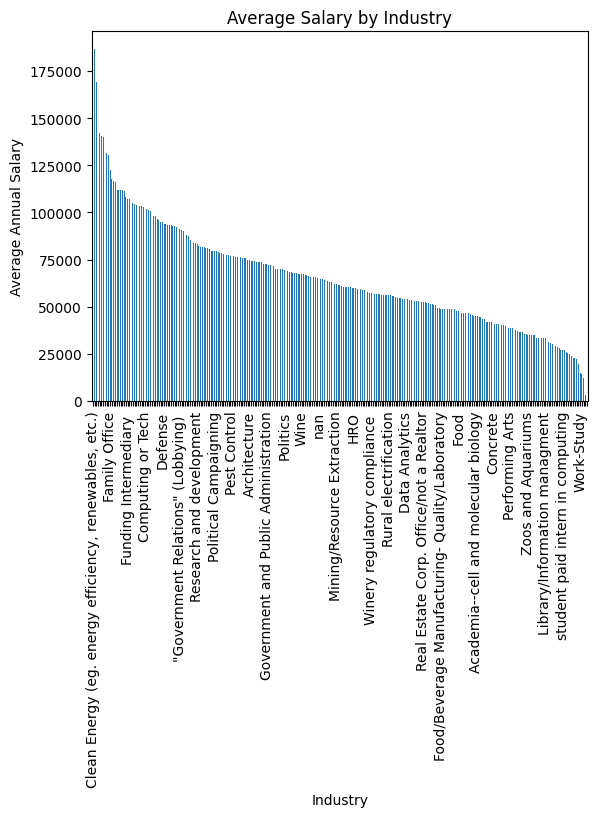

In [107]:
salary_average = salaries[['Industry','Total Remuneration EUR']]
list_pay_industry = salary_average.groupby("Industry")["Total Remuneration EUR"].mean().sort_values(ascending=False)
print(list_pay_industry)
list_industry = salary_average['Industry'].value_counts()
ax = list_pay_industry.plot(kind='bar')
plt.title("Average Salary by Industry")
plt.ylabel("Average Annual Salary")
plt.xlabel("Industry")
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 10) != 0:
        t.set_visible(False)


As we can see from the graph, barring the outliers we eliminated previously, the salaries range from around 175k a year to less than 25k, spanning multiple industries. It can be observed with some surprise that some Agricultural or Librarian average a higher average salary than posts like lobbying or FinTech, two domains which usually are considered as high paying.

    2. How does salary increase given years of experience?

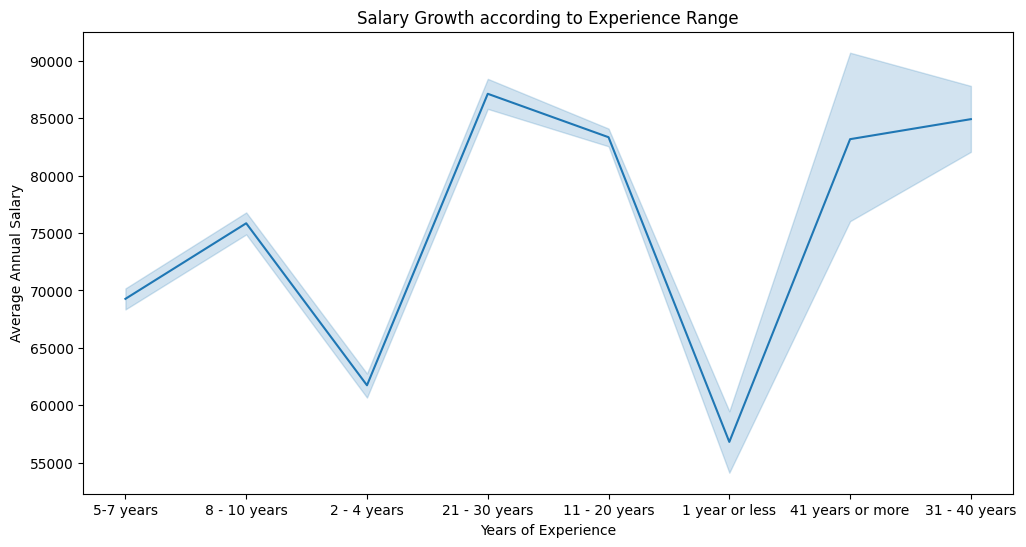

In [108]:
import seaborn as sns
# To order the ranges
plt.figure(figsize=(12, 6))
sns.lineplot(x=salaries["Experience"], y=salaries['Total Remuneration EUR'],estimator="mean")
plt.title("Salary Growth according to Experience Range")
plt.xlabel("Years of Experience")
plt.ylabel("Average Annual Salary")
plt.show()


    3. How do salaries compare for the same role in different locations?

C:\Users\33668\AppData\Local\Temp\ipykernel_18880\1114785823.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Remuneration EUR', y='Country', data=top_10_avg_remuneration_by_country, palette='magma')


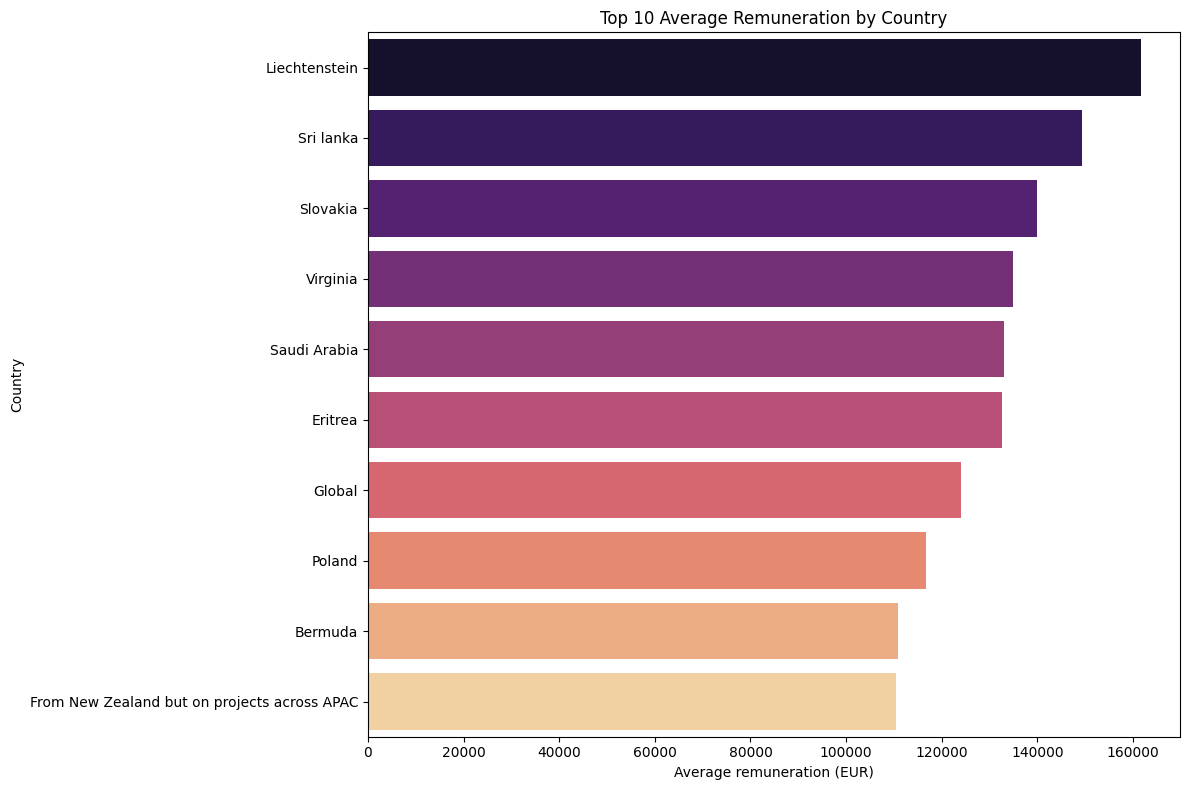

In [109]:
# Random values that we want to ignore
countries_to_ignore = ['Y', 'bonus based on meeting yearly goals set w/ my supervisor'] 

filtered_salaries = salaries[salaries['Country'].isin(countries_to_ignore) == False]


avg_remuneration_by_country = filtered_salaries.groupby('Country')['Total Remuneration EUR'].mean().reset_index()
avg_remuneration_by_country = avg_remuneration_by_country.sort_values(by='Total Remuneration EUR', ascending=False)

# Get only the top 10 values so that it is not ugly
top_10_avg_remuneration_by_country = avg_remuneration_by_country.head(10)


plt.figure(figsize=(12, 8))
sns.barplot(x='Total Remuneration EUR', y='Country', data=top_10_avg_remuneration_by_country, palette='magma')
plt.title('Top 10 Average Remuneration by Country')
plt.xlabel('Average remuneration (EUR)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


    4. How much do salaries differ by gender and years of experience?


C:\Users\33668\AppData\Local\Temp\ipykernel_18880\1954182672.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_salary_exp_gender = salaries.groupby(['Total Experience Level', 'Gender'])['Total Remuneration EUR'].mean().reset_index()


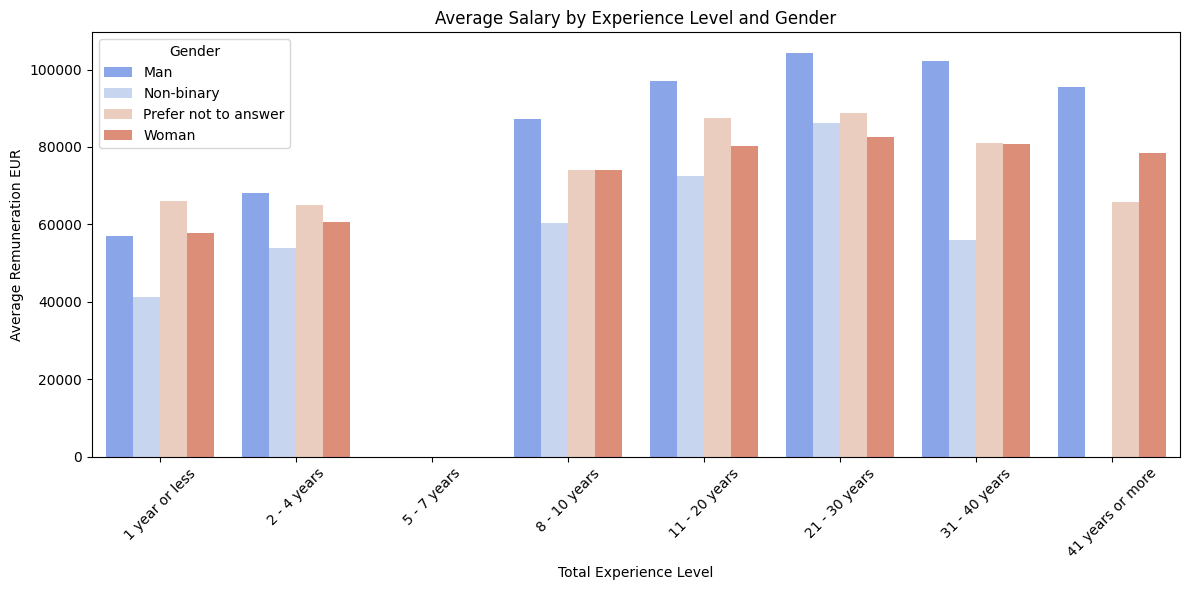

In [131]:
# Defining the order of experience levels because we left them as strings
experience_order = [
    '1 year or less',
    '2 - 4 years',
    '5 - 7 years',
    '8 - 10 years',
    '11 - 20 years',
    '21 - 30 years',
    '31 - 40 years',
    '41 years or more'
]

# Convert the 'Experience' column to a categorical type with the defined order 
salaries['Total Experience Level'] = pd.Categorical(salaries['Experience'], categories=experience_order, ordered=True)

avg_salary_exp_gender = salaries.groupby(['Total Experience Level', 'Gender'])['Total Remuneration EUR'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Total Experience Level', y='Total Remuneration EUR', hue='Gender', data=avg_salary_exp_gender, palette='coolwarm')
plt.title('Average Salary by Experience Level and Gender')
plt.xlabel('Total Experience Level')
plt.ylabel('Average Remuneration EUR')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


    5. How do factors like race and education level correlate with salary?

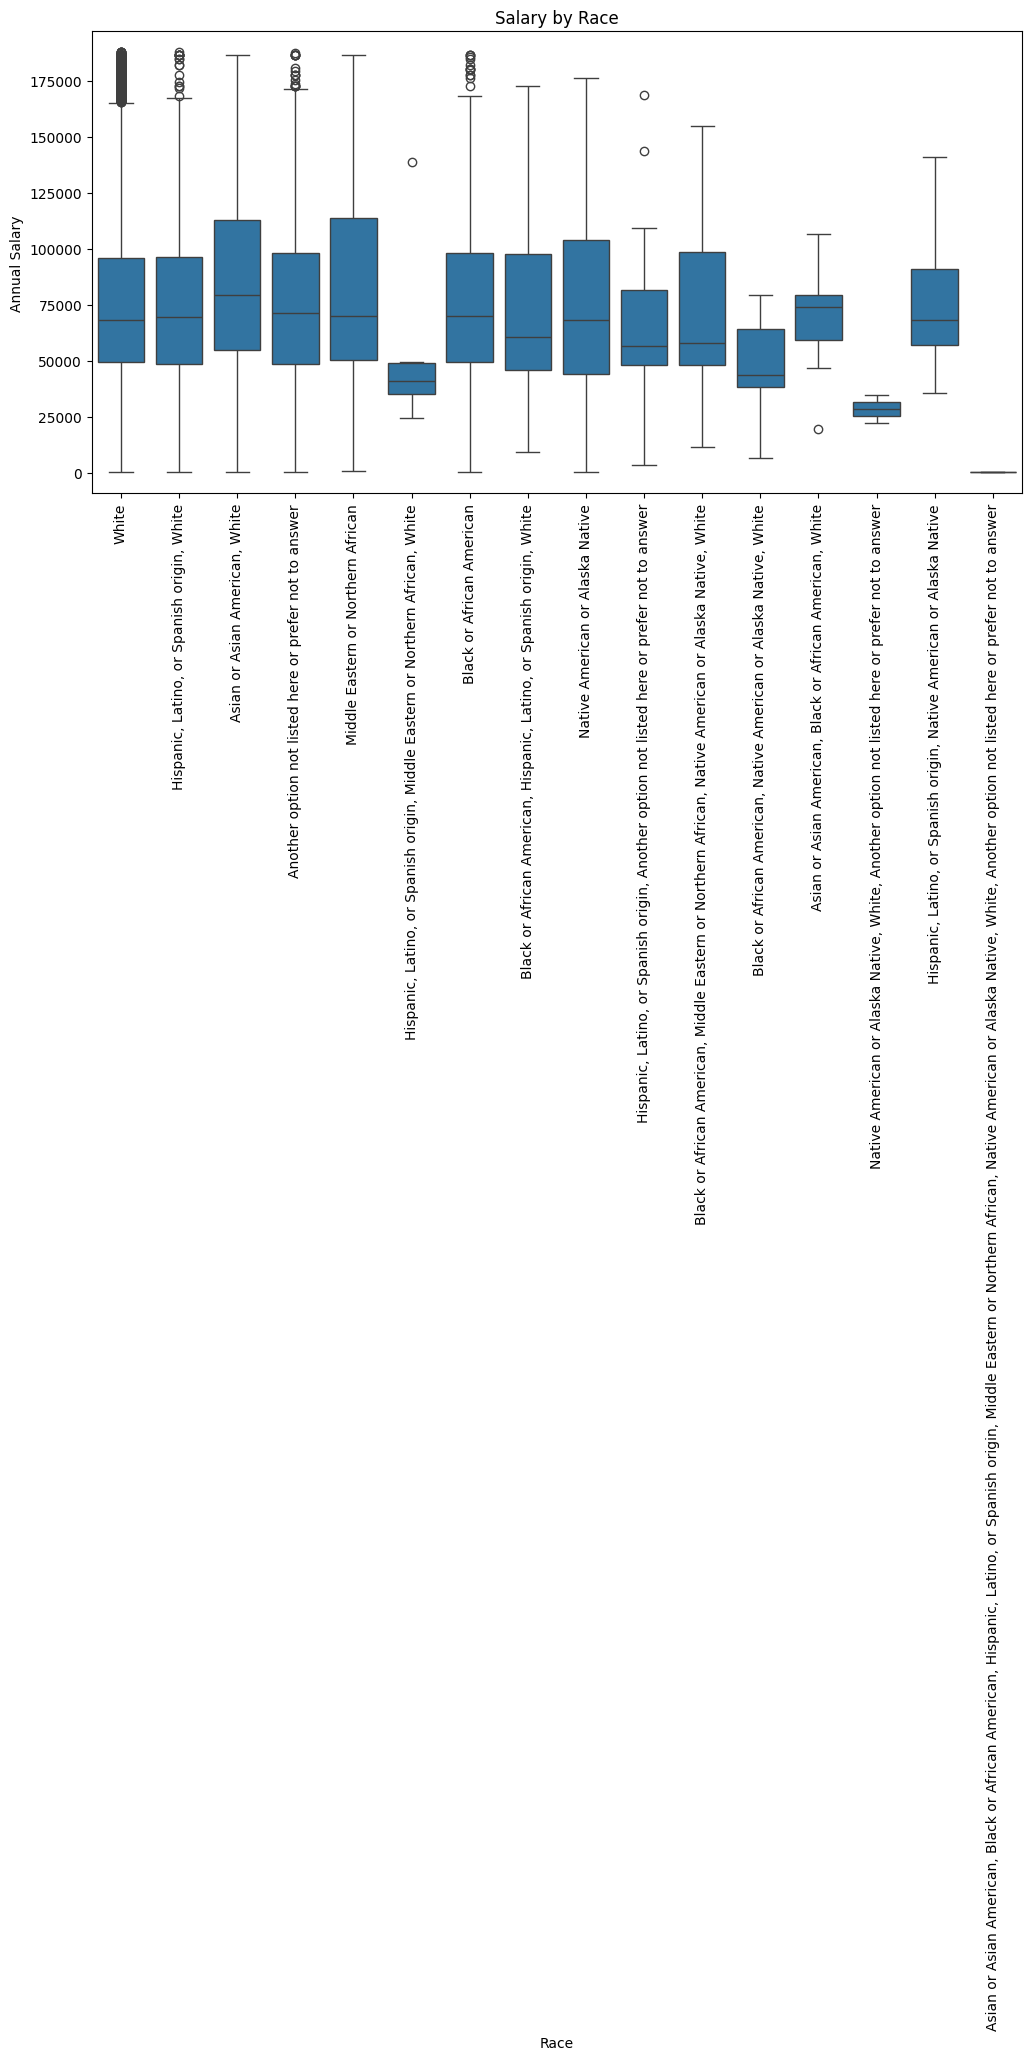

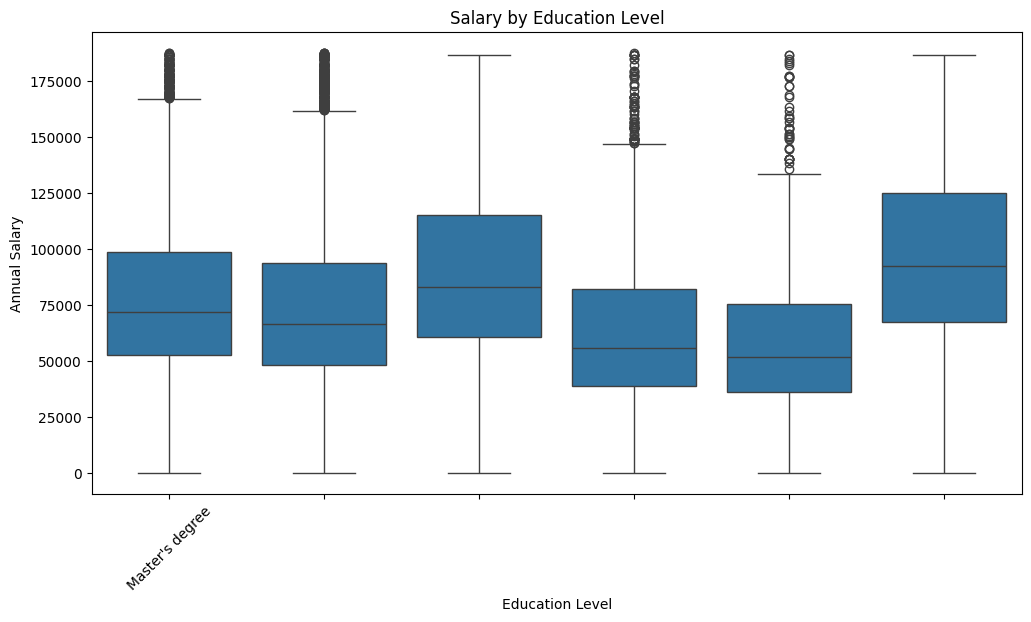

In [119]:
plt.figure(figsize=(12, 6))
sns.boxplot( x=salaries["Race"], y=salaries['Total Remuneration EUR'])
plt.title("Salary by Race")
plt.xlabel("Race")
plt.ylabel("Annual Salary")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x=salaries["Education"], y=salaries['Total Remuneration EUR'])
plt.title("Salary by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Annual Salary")
plt.xticks(rotation=45)


plt.show()


6. Is there a “sweet spot” total work experience vs years in the specific field?

C:\Users\33668\AppData\Local\Temp\ipykernel_18880\2447645534.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_remuneration_experience = salaries.groupby(['Field Experience Level', 'Total Experience Level'])['Total Remuneration EUR'].mean().reset_index()


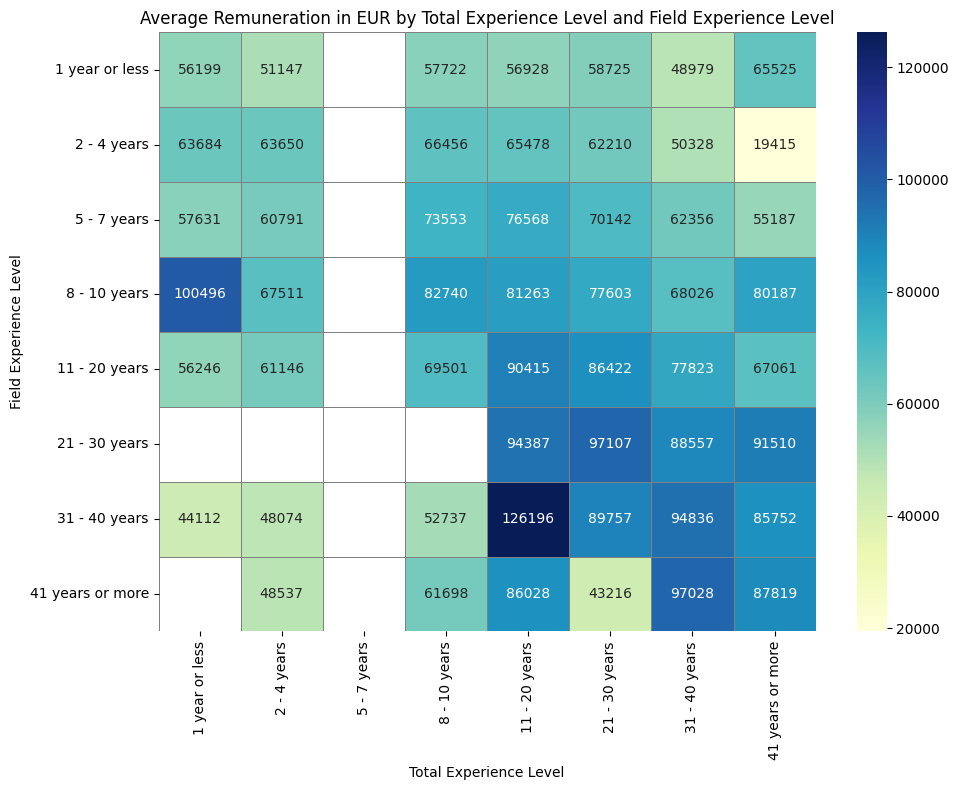

In [133]:
# Same thing as before to categorize the experience levels because they are strings
salaries['Field Experience Level'] = pd.Categorical(salaries['Field experience'], categories=experience_order, ordered=True)

avg_remuneration_experience = salaries.groupby(['Field Experience Level', 'Total Experience Level'])['Total Remuneration EUR'].mean().reset_index()

pivot_table = avg_remuneration_experience.pivot(index='Field Experience Level', columns='Total Experience Level', values='Total Remuneration EUR')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".0f",
    cmap='YlGnBu',
    linewidths=.5,
    linecolor='gray'
)
plt.title('Average Remuneration in EUR by Total Experience Level and Field Experience Level')
plt.xlabel('Total Experience Level')
plt.ylabel('Field Experience Level')
plt.tight_layout()
plt.show()
